In [1]:
from google.colab import drive, files
import pandas as pd
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
device_name = tf.test.gpu_device_name()

In [ ]:
#!unzip '/content/drive/MyDrive/Deep Learning/CarDetection.zip' -d '/content/drive/MyDrive/Deep Learning'

## Data Analysis

In [ ]:
#Create Dataframes
namesDF = pd.read_csv('/content/drive/MyDrive/Deep Learning/names.csv', header=None)
namesDF.columns = ['Names']
trainLabels = pd.read_csv('/content/drive/MyDrive/Deep Learning/anno_train.csv', header=None)
testLabels = pd.read_csv('/content/drive/MyDrive/Deep Learning/anno_test.csv', header=None)

In [ ]:
namesDF.head(10)

,Names
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
5,Acura Integra Type R 2001
6,Acura ZDX Hatchback 2012
7,Aston Martin V8 Vantage Convertible 2012
8,Aston Martin V8 Vantage Coupe 2012
9,Aston Martin Virage Convertible 2012


In [ ]:
trainLabels.head(10)

,0,1,2,3,4,5
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
5,00006.jpg,259,289,515,416,123
6,00007.jpg,88,80,541,397,89
7,00008.jpg,73,79,591,410,96
8,00009.jpg,20,126,1269,771,167
9,00010.jpg,21,110,623,367,58


In [ ]:
testLabels.head(10)

,0,1,2,3,4,5
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
5,00006.jpg,20,77,420,301,78
6,00007.jpg,249,166,2324,1459,118
7,00008.jpg,119,215,1153,719,165
8,00009.jpg,1,7,275,183,32
9,00010.jpg,28,55,241,177,60


In [ ]:
#Not sure if the coordinate columns are necessary, so I will remove them for now.
trainLabels.drop(columns=trainLabels.columns[1:-1], axis=1, inplace=True)
trainLabels.columns = ['Image Label', 'Name List Index']
trainLabels.head(10)

,Image Label,Name List Index
0,00001.jpg,14
1,00002.jpg,3
2,00003.jpg,91
3,00004.jpg,134
4,00005.jpg,106
5,00006.jpg,123
6,00007.jpg,89
7,00008.jpg,96
8,00009.jpg,167
9,00010.jpg,58


In [ ]:
testLabels.drop(columns=testLabels.columns[1:-1], axis=1, inplace=True)
testLabels.columns = ['Image Label', 'Name List Index']
testLabels.head(10)

,Image Label,Name List Index
0,00001.jpg,181
1,00002.jpg,103
2,00003.jpg,145
3,00004.jpg,187
4,00005.jpg,185
5,00006.jpg,78
6,00007.jpg,118
7,00008.jpg,165
8,00009.jpg,32
9,00010.jpg,60


In [ ]:
#Make a dataframe including the names corresponding to the indexes.
#Here is the training set.
trainNames = []
for index in trainLabels['Name List Index']:
  name = namesDF['Names'][index-1]
  trainNames.append(name)

trainLabels['Names'] = trainNames
trainLabels.head(10)

,Image Label,Name List Index,Names
0,00001.jpg,14,Audi TTS Coupe 2012
1,00002.jpg,3,Acura TL Sedan 2012
2,00003.jpg,91,Dodge Dakota Club Cab 2007
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012
5,00006.jpg,123,Geo Metro Convertible 1993
6,00007.jpg,89,Dodge Journey SUV 2012
7,00008.jpg,96,Dodge Charger Sedan 2012
8,00009.jpg,167,Mitsubishi Lancer Sedan 2012
9,00010.jpg,58,Chevrolet Traverse SUV 2012


In [ ]:
#Do same thing for test set.
testNames = []
for index in testLabels['Name List Index']:
  name = namesDF['Names'][index-1]
  testNames.append(name)

testLabels['Names'] = testNames
testLabels.head(10)

,Image Label,Name List Index,Names
0,00001.jpg,181,Suzuki Aerio Sedan 2007
1,00002.jpg,103,Ferrari 458 Italia Convertible 2012
2,00003.jpg,145,Jeep Patriot SUV 2012
3,00004.jpg,187,Toyota Camry Sedan 2012
4,00005.jpg,185,Tesla Model S Sedan 2012
5,00006.jpg,78,Chrysler Town and Country Minivan 2012
6,00007.jpg,118,GMC Terrain SUV 2012
7,00008.jpg,165,Mercedes-Benz S-Class Sedan 2012
8,00009.jpg,32,BMW X5 SUV 2007
9,00010.jpg,60,Chevrolet HHR SS 2010


In [ ]:
#Now the 'Names' column for each the training and test dataframes will be our y-values/ground truths.

In [ ]:
#Split the labels into lists of Makes, Models, Types, and Years
trainMakeAndModels =[]; trainCarTypes =[]; years =[]
for label in trainNames:
  makeAndModel, carType, year = label.rsplit(' ', 1)
  trainMakeAndModels.append(makeAndModel)
  trainCarTypes.append(carType)
  years.append(year)

makes =[]; models =[]
for i in trainMakeAndModels:
  make, model = i.split(' ', 1)
  makes.append(make)
  models.append(model)

print(makes)
print(models)
print(trainCarTypes)
print(years)

In [ ]:
#Check the types are accurately labeled.
checkTypes = np.array(trainCarTypes)
uniqTypes = np.unique(checkTypes)
print(uniqTypes)

['Abarth' 'Cab' 'Convertible' 'Coupe' 'GS' 'Hatchback' 'IPL' 'Minivan' 'R'
 'SRT-8' 'SRT8' 'SS' 'SUV' 'Sedan' 'SuperCab' 'Superleggera' 'Type-S'
 'Van' 'Wagon' 'XKR' 'Z06' 'ZR1']


In [ ]:
#Some of these do not include the type of the car (Sedan, coup, van, etc....) so we may need to get rid of those instances

In [ ]:
totalUnlabeledTypes = 0
for inst in uniqTypes:
  if inst=='Cab' or inst=='Convertible' or inst=='Coupe' or inst=='Hatchback' or inst=='Minivan' or inst=='SUV'\
  or inst=='Sedan' or inst=='Van' or inst=='Wagon':
    pass
  else:
    print('Instances of %s is %d' %(inst, trainCarTypes.count(inst)))
    totalUnlabeledTypes += trainCarTypes.count(inst)

print(' ')
print('Total samples with no given car type is %d.' % totalUnlabeledTypes)
print(len(trainCarTypes))
print('Percentage of unusable labels for type of car: %d percent.' % ((totalUnlabeledTypes/len(trainCarTypes))*100))

Instances of Abarth is 28
Instances of GS is 35
Instances of IPL is 34
Instances of R is 45
Instances of SRT-8 is 91
Instances of SRT8 is 39
Instances of SS is 119
Instances of SuperCab is 42
Instances of Superleggera is 36
Instances of Type-S is 42
Instances of XKR is 47
Instances of Z06 is 38
Instances of ZR1 is 47
 
Total samples with no given car type is 643.
8144
Percentage of unusable labels for type of car: 7 percent.


In [ ]:
#So unfortunately there are 896 instances that don't include the type of the car. This will be an issue if we split the label
#into 3 separate labels. We can either delete all of those samples or just not include the label for the type of car in 
#general and leave the model to train only one make, model, and year.
#brayan: I would split into 2 separate labels, one for maker and the second for the remaining text of the class
#Robert: if we add Wagon we now have 7 percent.  But I agree that splitting the manufacturer(Make) and the rest will help with clearing those
  # inconsistences in the names.      

In [ ]:
#Robert: This is splitting the 'Names' column at the first space, to give us the Make/manufacturer.

df1=testLabels

df1['makes'] = df1['Names'].str.split(n=1).str[0]  # create 'First Name' column with first word
df1['model_type_year'] = df1['Names'].str.split(n=1).str[1:] 
df1['model_type_year'] = df1['model_type_year'].str.join(' ') 
df1.head()

,Image Label,Name List Index,Names,makes,model_type_year
0,00001.jpg,181,Suzuki Aerio Sedan 2007,Suzuki,Aerio Sedan 2007
1,00002.jpg,103,Ferrari 458 Italia Convertible 2012,Ferrari,458 Italia Convertible 2012
2,00003.jpg,145,Jeep Patriot SUV 2012,Jeep,Patriot SUV 2012
3,00004.jpg,187,Toyota Camry Sedan 2012,Toyota,Camry Sedan 2012
4,00005.jpg,185,Tesla Model S Sedan 2012,Tesla,Model S Sedan 2012


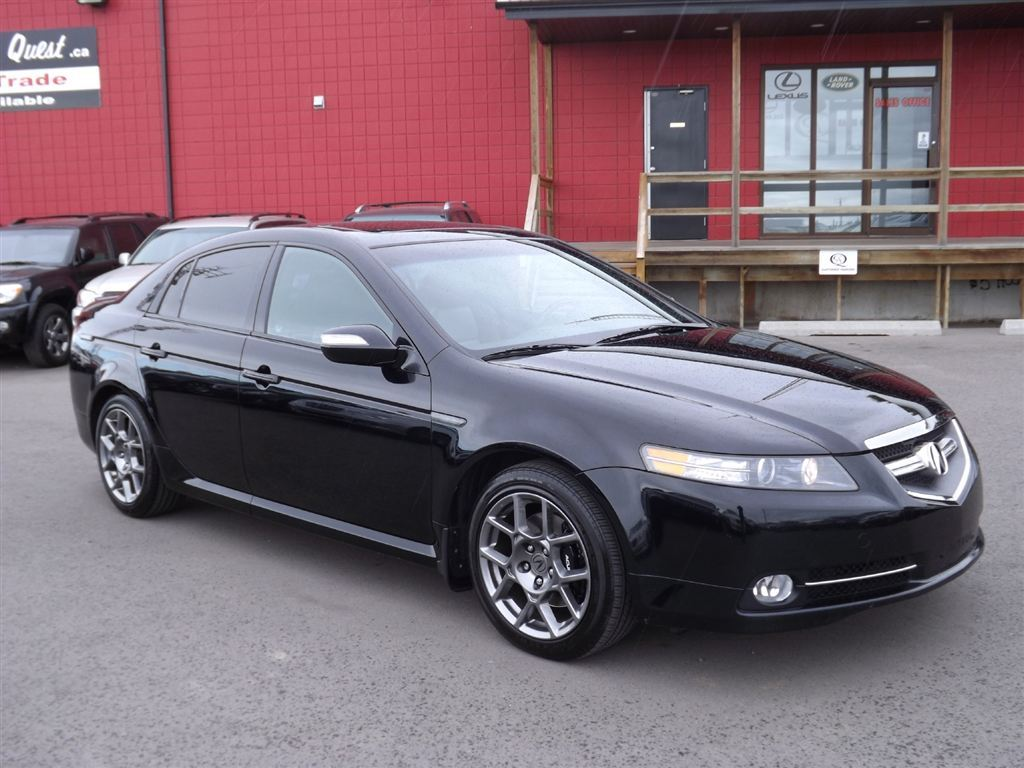

In [ ]:
#Let's look at an example of an image in the dataset.
import cv2
from google.colab.patches import cv2_imshow
randomImagePath = '/content/drive/MyDrive/Deep Learning/car_data/car_data/train/Acura TL Type-S 2008/00392.jpg'
randomImg = cv2.imread(randomImagePath)
cv2_imshow(randomImg)

In [ ]:
print(randomImg.shape)

(768, 1024, 3)


## Data Augmentation

In [ ]:
def plotAugmentations(augImages):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(augImages, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Test on a single image first.

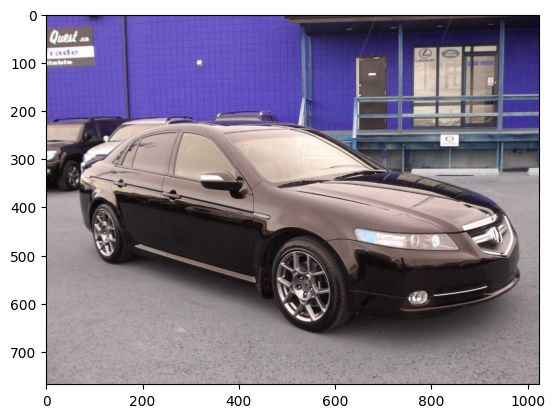

In [ ]:
#Test
image = np.expand_dims(randomImg,0)
plt.imshow(image[0])

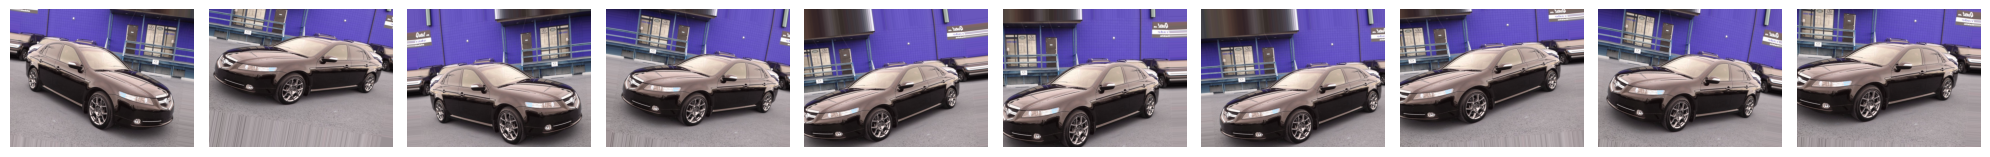

In [ ]:
dataAug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, horizontal_flip=True)
aug_iter = dataAug.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotAugmentations(aug_images)

### Now implement.

In [ ]:
#This section was moved to the DL_DataPreprocessing notebook.
import os
dataAug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, horizontal_flip=True)  
trainFolder = '/content/drive/MyDrive/Deep Learning/car_data/car_data/train'
for folder in os.listdir(trainFolder):
  save_in = os.path.join(trainFolder, folder)
  for image in os.listdir(os.path.join(trainFolder, folder)):
    currentImg = os.path.join(save_in, image)
    readImg = cv2.imread(currentImg)
    im2aug = np.expand_dims(readImg,0)
    aug_iter = dataAug.flow(im2aug, save_to_dir=save_in, save_prefix='aug', save_format='jpg')
    #aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(5)]

## Define Test, Train, and Validation Sets

#### Original Dataset

In [ ]:
#This is for the original dataset given as is with no preprocessing.
train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/car_data/car_data/train', labels='inferred',
    image_size=(180, 180),
    batch_size=32,
)
validation = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/car_data/car_data/test', labels='inferred', validation_split=0.5,
    subset='training', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)
test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/car_data/car_data/test', labels='inferred', validation_split=0.5,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)

Found 8088 files belonging to 196 classes.
Found 7985 files belonging to 196 classes.
Using 3993 files for training.
Found 7985 files belonging to 196 classes.
Using 3992 files for validation.


#### New Test/Train Split

In [ ]:
#Here are new subsets from altered dataset, moving half of the test images to the training set.
train2 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/train', labels='inferred',
    image_size=(180, 180),
    batch_size=32,
)
validation2 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/test', labels='inferred', validation_split=0.4,
    subset='training', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)
test2 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/test', labels='inferred', validation_split=0.4,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)

Found 12090 files belonging to 196 classes.
Found 3983 files belonging to 196 classes.
Using 1594 files for training.
Found 3983 files belonging to 196 classes.
Using 1593 files for validation.


In [ ]:
#Here are new subsets from altered dataset, moving half of the test images to the training set.
#Try taking validation from training.
train3 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/train', color_mode='grayscale', labels='inferred', validation_split=0.3,
    subset='training', shuffle=True,
    seed=100,
    image_size=(250, 250),
    batch_size=32,
)
validation3 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/train', color_mode='grayscale', labels='inferred', validation_split=0.3,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(250, 250),
    batch_size=32,
)
test3 = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/Keras/car_data/car_data/test', color_mode='grayscale', labels='inferred',
    image_size=(250, 250), shuffle=False,
    batch_size=32,
)

Found 12090 files belonging to 196 classes.
Using 8463 files for training.
Found 12090 files belonging to 196 classes.
Using 3627 files for validation.
Found 3983 files belonging to 196 classes.


In [ ]:
#Make sure labels are correct.
plt.figure(figsize=(10, 20))
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True)
 
for images, labels in validation3.take(1):
    for i in range(3):
        for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].set_title(validation3.class_names[labels[i*3+j]])
plt.show()

#### Dataset Separated By Car Make

In [ ]:
#For dataset split into folders by Make:
MakeTrain = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByMake/car_data/car_data/train', color_mode='grayscale', labels='inferred',
    image_size=(180, 180),
    batch_size=32,
)
MakeValidation = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByMake/car_data/car_data/test', color_mode='grayscale', labels='inferred', validation_split=0.5,
    subset='training', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)
MakeTest = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByMake/car_data/car_data/test', color_mode='grayscale', labels='inferred', validation_split=0.5,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(180, 180),
    batch_size=32,
)

Found 8144 files belonging to 48 classes.
Found 8027 files belonging to 48 classes.
Using 4014 files for training.
Found 8027 files belonging to 48 classes.
Using 4013 files for validation.


#### Dataset Separated By Vehicle Type

In [3]:
#For dataset split by vehicle type (Sedan, Coupe, Van, etc.)
TypeTrain = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByType/car_data/car_data/train', color_mode='grayscale', labels='inferred', validation_split=0.2,
    subset='training', shuffle=True,
    seed=100,
    image_size=(224, 224),
    batch_size=32,
)
TypeVal = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByType/car_data/car_data/train', color_mode='grayscale', labels='inferred', validation_split=0.2,
    subset='validation', shuffle=True,
    seed=100,
    image_size=(224, 224),
    batch_size=32,
)
TypeTest = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/SeparatedByType/car_data/car_data/test', color_mode='grayscale', labels='inferred',
    image_size=(224, 224), shuffle=False,
    batch_size=32,
)

Found 11289 files belonging to 9 classes.
Using 9032 files for training.
Found 11289 files belonging to 9 classes.
Using 2257 files for validation.
Found 3747 files belonging to 9 classes.


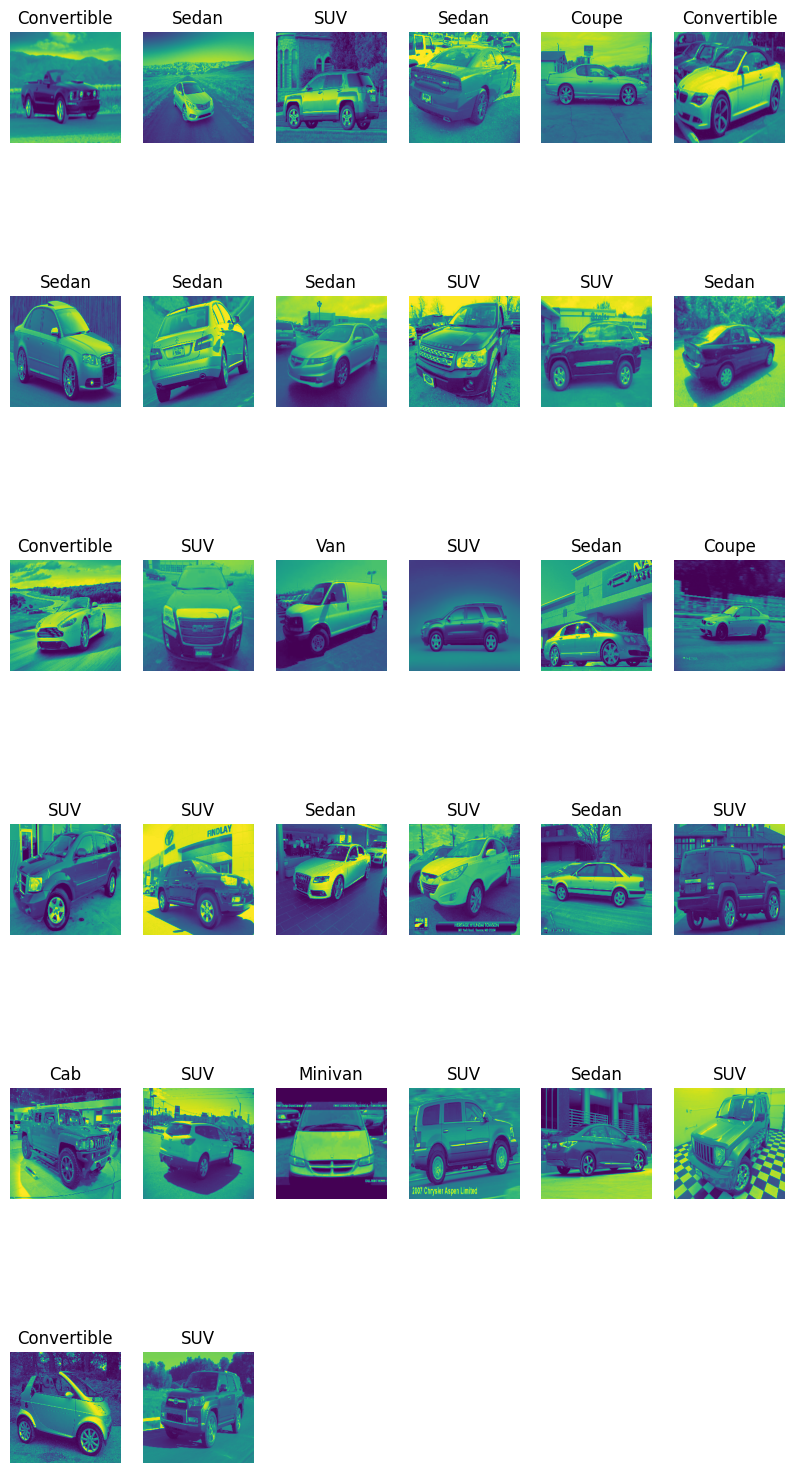

In [ ]:
#Make sure our split kept our data labeled correctly.
plt.figure(figsize=(10, 20))
for images, labels in TypeVal.take(1):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(TypeVal.class_names[labels[i]])
        plt.axis("off")

#### Enlarged Dataset Including Augmented Images

In [ ]:
#For dataset with data augmentation:
augTrain = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/DataWithAugmentation/car_data/car_data/train', color_mode='grayscale', labels='inferred',
    image_size=(224, 224),
    batch_size=32,
)
augVal = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/DataWithAugmentation/car_data/car_data/validation', color_mode='grayscale', labels='inferred',
    image_size=(224, 224), shuffle=False,
    batch_size=32,
)
augTest = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Deep Learning/DataWithAugmentation/car_data/car_data/test', color_mode='grayscale', labels='inferred',
    shuffle=False,
    image_size=(224, 224),
    batch_size=32,
)

Found 32228 files belonging to 196 classes.
Found 3970 files belonging to 196 classes.
Found 3973 files belonging to 196 classes.


In [ ]:
#No longer need this because I am using grayscale.
#def norm(image,label):
#    image = tf.cast(image/255.,tf.float32)
#    return image,label

#train = train.map(norm)
#test = train.map(norm)


# Make Model

## Model for 196 classes

In [4]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomTranslation(0.15,0.15)
])

In [ ]:
with tf.device(device_name):
  model = models.Sequential()
  model.add(data_augmentation)
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(196, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)     

In [ ]:
from keras.callbacks import ModelCheckpoint
callbacks = [
    ModelCheckpoint(filepath="/content/drive/MyDrive/Deep Learning/SavedModels", 
                             monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')]

In [ ]:
with tf.device(device_name):
  model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train3, epochs=300, callbacks=callbacks, validation_data=validation3)

## Model For Classifying Vehicle Type

In [ ]:
with tf.device(device_name):
  Type_model = models.Sequential()
  Type_model.add(data_augmentation)
  Type_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
  Type_model.add(layers.BatchNormalization())
  Type_model.add(layers.MaxPooling2D((2, 2)))
  Type_model.add(layers.Dropout(0.25))

  Type_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  Type_model.add(layers.BatchNormalization())
  Type_model.add(layers.MaxPooling2D((2, 2)))
  Type_model.add(layers.Dropout(0.25))

  Type_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  Type_model.add(layers.BatchNormalization())
  Type_model.add(layers.MaxPooling2D((2, 2)))
  Type_model.add(layers.Dropout(0.25))

  Type_model.add(layers.Flatten())
  Type_model.add(layers.Dense(512, activation='relu'))
  Type_model.add(layers.BatchNormalization())
  Type_model.add(layers.Dropout(0.5))
  Type_model.add(layers.Dense(9, activation='softmax'))

In [ ]:
Type_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)     

In [ ]:
from keras.callbacks import ModelCheckpoint
Type_callbacks = [
    ModelCheckpoint(filepath="/content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType", 
                             monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')]

In [ ]:
#Train Model
with tf.device(device_name):
  Type_model.compile(optimizer=tf.keras.optimizers.Adam(3e-3),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Type_hist = Type_model.fit(TypeTrain, epochs=500, callbacks=Type_callbacks, validation_data=TypeVal)

Epoch 1/500
283/283 [==============================] - ETA: 0s - loss: 2.6054 - accuracy: 0.1905
Epoch 1: val_accuracy improved from -inf to 0.19716, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 61s 184ms/step - loss: 2.6054 - accuracy: 0.1905 - val_loss: 2.2848 - val_accuracy: 0.1972
Epoch 2/500
282/283 [============================>.] - ETA: 0s - loss: 2.1947 - accuracy: 0.2118
Epoch 2: val_accuracy improved from 0.19716 to 0.20160, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 54s 187ms/step - loss: 2.1945 - accuracy: 0.2117 - val_loss: 2.9743 - val_accuracy: 0.2016
Epoch 3/500
282/283 [============================>.] - ETA: 0s - loss: 2.1272 - accuracy: 0.2215
Epoch 3: val_accuracy improved from 0.20160 to 0.22641, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 57s 197ms/step - loss: 2.1273 - accuracy: 0.2217 - val_loss: 2.2767 - val_accuracy: 0.2264
Epoch 4/500
282/283 [============================>.] - ETA: 0s - loss: 2.1008 - accuracy: 0.2246
Epoch 4: val_accuracy did not improve from 0.22641
283/283 [==============================] - 46s 161ms/step - loss: 2.1004 - accuracy: 0.2246 - val_loss: 3.0873 - val_accuracy: 0.1684
Epoch 5/500
282/283 [============================>.] - ETA: 0s - loss: 2.0551 - accuracy: 0.2307
Epoch 5: val_accuracy did not improve from 0.22641
283/283 [==============================] - 48s 167ms/step - loss: 2.0554 - accuracy: 0.2306 - val_loss: 3.1377 - val_accuracy: 0.1808
Epoch 6/500
282/283 [============================>.] - ETA: 0s - loss: 2.0322 - accuracy: 0.2376
Epoch 6: val_accuracy did not improve from 0.22641
283/283 [==============================] - 48s 167ms/step - loss: 2.0324 - accuracy: 0.2375 - val_loss: 2.1206 - val_accuracy: 0.2264
Epoch 7/500
282/283 

283/283 [==============================] - 52s 183ms/step - loss: 2.0020 - accuracy: 0.2462 - val_loss: 1.9922 - val_accuracy: 0.2415
Epoch 8/500
282/283 [============================>.] - ETA: 0s - loss: 1.9801 - accuracy: 0.2548
Epoch 8: val_accuracy improved from 0.24147 to 0.24280, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 53s 184ms/step - loss: 1.9802 - accuracy: 0.2549 - val_loss: 2.8022 - val_accuracy: 0.2428
Epoch 9/500
282/283 [============================>.] - ETA: 0s - loss: 1.9654 - accuracy: 0.2523
Epoch 9: val_accuracy did not improve from 0.24280
283/283 [==============================] - 47s 165ms/step - loss: 1.9654 - accuracy: 0.2523 - val_loss: 2.0818 - val_accuracy: 0.2268
Epoch 10/500
282/283 [============================>.] - ETA: 0s - loss: 1.9605 - accuracy: 0.2681
Epoch 10: val_accuracy improved from 0.24280 to 0.25166, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 57s 197ms/step - loss: 1.9602 - accuracy: 0.2682 - val_loss: 1.9826 - val_accuracy: 0.2517
Epoch 11/500
282/283 [============================>.] - ETA: 0s - loss: 1.9415 - accuracy: 0.2656
Epoch 11: val_accuracy improved from 0.25166 to 0.27559, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 55s 191ms/step - loss: 1.9414 - accuracy: 0.2656 - val_loss: 1.9160 - val_accuracy: 0.2756
Epoch 12/500
282/283 [============================>.] - ETA: 0s - loss: 1.9264 - accuracy: 0.2713
Epoch 12: val_accuracy did not improve from 0.27559
283/283 [==============================] - 48s 167ms/step - loss: 1.9267 - accuracy: 0.2713 - val_loss: 1.9745 - val_accuracy: 0.2619
Epoch 13/500
282/283 [============================>.] - ETA: 0s - loss: 1.9106 - accuracy: 0.2812
Epoch 13: val_accuracy did not improve from 0.27559
283/283 [==============================] - 46s 160ms/step - loss: 1.9108 - accuracy: 0.2811 - val_loss: 2.3146 - val_accuracy: 0.2034
Epoch 14/500
282/283 [============================>.] - ETA: 0s - loss: 1.9090 - accuracy: 0.2758
Epoch 14: val_accuracy did not improve from 0.27559
283/283 [==============================] - 46s 161ms/step - loss: 1.9092 - accuracy: 0.2756 - val_loss: 2.0905 - val_accuracy: 0.2627
Epoch 15/500
2

283/283 [==============================] - 53s 185ms/step - loss: 1.8911 - accuracy: 0.2864 - val_loss: 1.9272 - val_accuracy: 0.2787
Epoch 16/500
282/283 [============================>.] - ETA: 0s - loss: 1.8834 - accuracy: 0.2887
Epoch 16: val_accuracy did not improve from 0.27869
283/283 [==============================] - 48s 164ms/step - loss: 1.8835 - accuracy: 0.2885 - val_loss: 1.9957 - val_accuracy: 0.2685
Epoch 17/500
282/283 [============================>.] - ETA: 0s - loss: 1.8931 - accuracy: 0.2859
Epoch 17: val_accuracy did not improve from 0.27869
283/283 [==============================] - 46s 159ms/step - loss: 1.8932 - accuracy: 0.2861 - val_loss: 2.2408 - val_accuracy: 0.2180
Epoch 18/500
282/283 [============================>.] - ETA: 0s - loss: 1.8796 - accuracy: 0.2918
Epoch 18: val_accuracy did not improve from 0.27869
283/283 [==============================] - 47s 162ms/step - loss: 1.8806 - accuracy: 0.2915 - val_loss: 2.2087 - val_accuracy: 0.2158
Epoch 19/500
2

283/283 [==============================] - 52s 183ms/step - loss: 1.8101 - accuracy: 0.3195 - val_loss: 1.8516 - val_accuracy: 0.3075
Epoch 28/500
282/283 [============================>.] - ETA: 0s - loss: 1.7939 - accuracy: 0.3248
Epoch 28: val_accuracy improved from 0.30749 to 0.31059, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 53s 186ms/step - loss: 1.7940 - accuracy: 0.3246 - val_loss: 1.8044 - val_accuracy: 0.3106
Epoch 29/500
282/283 [============================>.] - ETA: 0s - loss: 1.8097 - accuracy: 0.3194
Epoch 29: val_accuracy did not improve from 0.31059
283/283 [==============================] - 47s 165ms/step - loss: 1.8100 - accuracy: 0.3194 - val_loss: 2.0304 - val_accuracy: 0.2029
Epoch 30/500
282/283 [============================>.] - ETA: 0s - loss: 1.8616 - accuracy: 0.2982
Epoch 30: val_accuracy did not improve from 0.31059
283/283 [==============================] - 50s 175ms/step - loss: 1.8613 - accuracy: 0.2985 - val_loss: 1.8773 - val_accuracy: 0.2907
Epoch 31/500
282/283 [============================>.] - ETA: 0s - loss: 1.8346 - accuracy: 0.3121
Epoch 31: val_accuracy did not improve from 0.31059
283/283 [==============================] - 46s 159ms/step - loss: 1.8348 - accuracy: 0.3120 - val_loss: 2.1617 - val_accuracy: 0.1901
Epoch 32/500
2

283/283 [==============================] - 54s 188ms/step - loss: 1.8166 - accuracy: 0.3182 - val_loss: 1.7432 - val_accuracy: 0.3429
Epoch 34/500
282/283 [============================>.] - ETA: 0s - loss: 1.7745 - accuracy: 0.3282
Epoch 34: val_accuracy did not improve from 0.34293
283/283 [==============================] - 48s 165ms/step - loss: 1.7744 - accuracy: 0.3283 - val_loss: 1.9571 - val_accuracy: 0.2924
Epoch 35/500
282/283 [============================>.] - ETA: 0s - loss: 1.7616 - accuracy: 0.3425
Epoch 35: val_accuracy did not improve from 0.34293
283/283 [==============================] - 46s 160ms/step - loss: 1.7614 - accuracy: 0.3427 - val_loss: 1.7948 - val_accuracy: 0.3354
Epoch 36/500
282/283 [============================>.] - ETA: 0s - loss: 1.7609 - accuracy: 0.3334
Epoch 36: val_accuracy did not improve from 0.34293
283/283 [==============================] - 50s 175ms/step - loss: 1.7606 - accuracy: 0.3336 - val_loss: 3.3631 - val_accuracy: 0.2725
Epoch 37/500
2

283/283 [==============================] - 54s 187ms/step - loss: 1.7820 - accuracy: 0.3278 - val_loss: 1.7712 - val_accuracy: 0.3682
Epoch 48/500
282/283 [============================>.] - ETA: 0s - loss: 1.7754 - accuracy: 0.3336
Epoch 48: val_accuracy did not improve from 0.36819
283/283 [==============================] - 52s 180ms/step - loss: 1.7757 - accuracy: 0.3333 - val_loss: 1.6941 - val_accuracy: 0.3558
Epoch 49/500
282/283 [============================>.] - ETA: 0s - loss: 1.7513 - accuracy: 0.3390
Epoch 49: val_accuracy did not improve from 0.36819
283/283 [==============================] - 48s 166ms/step - loss: 1.7514 - accuracy: 0.3390 - val_loss: 1.7890 - val_accuracy: 0.3381
Epoch 50/500
282/283 [============================>.] - ETA: 0s - loss: 1.7221 - accuracy: 0.3531
Epoch 50: val_accuracy did not improve from 0.36819
283/283 [==============================] - 46s 161ms/step - loss: 1.7222 - accuracy: 0.3530 - val_loss: 1.8776 - val_accuracy: 0.3155
Epoch 51/500
2

283/283 [==============================] - 56s 192ms/step - loss: 1.7256 - accuracy: 0.3513 - val_loss: 30.4870 - val_accuracy: 0.3837
Epoch 77/500
282/283 [============================>.] - ETA: 0s - loss: 1.6938 - accuracy: 0.3630
Epoch 77: val_accuracy did not improve from 0.38370
283/283 [==============================] - 49s 171ms/step - loss: 1.6937 - accuracy: 0.3630 - val_loss: 172.0893 - val_accuracy: 0.3536
Epoch 78/500
282/283 [============================>.] - ETA: 0s - loss: 1.7452 - accuracy: 0.3394
Epoch 78: val_accuracy did not improve from 0.38370
283/283 [==============================] - 46s 160ms/step - loss: 1.7452 - accuracy: 0.3393 - val_loss: 1.9053 - val_accuracy: 0.3460
Epoch 79/500
282/283 [============================>.] - ETA: 0s - loss: 1.7166 - accuracy: 0.3542
Epoch 79: val_accuracy did not improve from 0.38370
283/283 [==============================] - 51s 176ms/step - loss: 1.7167 - accuracy: 0.3542 - val_loss: 1.6817 - val_accuracy: 0.3686
Epoch 80/50

283/283 [==============================] - 53s 184ms/step - loss: 1.6875 - accuracy: 0.3654 - val_loss: 1.9349 - val_accuracy: 0.3908
Epoch 81/500
282/283 [============================>.] - ETA: 0s - loss: 1.6885 - accuracy: 0.3711
Epoch 81: val_accuracy did not improve from 0.39078
283/283 [==============================] - 47s 162ms/step - loss: 1.6889 - accuracy: 0.3709 - val_loss: 2.9655 - val_accuracy: 0.2689
Epoch 82/500
282/283 [============================>.] - ETA: 0s - loss: 1.7386 - accuracy: 0.3456
Epoch 82: val_accuracy did not improve from 0.39078
283/283 [==============================] - 50s 175ms/step - loss: 1.7386 - accuracy: 0.3455 - val_loss: 2.0650 - val_accuracy: 0.3589
Epoch 83/500
282/283 [============================>.] - ETA: 0s - loss: 1.6860 - accuracy: 0.3666
Epoch 83: val_accuracy improved from 0.39078 to 0.39123, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 54s 188ms/step - loss: 1.6857 - accuracy: 0.3668 - val_loss: 2.3279 - val_accuracy: 0.3912
Epoch 84/500
282/283 [============================>.] - ETA: 0s - loss: 1.6925 - accuracy: 0.3700
Epoch 84: val_accuracy did not improve from 0.39123
283/283 [==============================] - 49s 172ms/step - loss: 1.6926 - accuracy: 0.3699 - val_loss: 3.4833 - val_accuracy: 0.3895
Epoch 85/500
282/283 [============================>.] - ETA: 0s - loss: 1.6742 - accuracy: 0.3719
Epoch 85: val_accuracy did not improve from 0.39123
283/283 [==============================] - 48s 167ms/step - loss: 1.6742 - accuracy: 0.3720 - val_loss: 2.3944 - val_accuracy: 0.3788
Epoch 86/500
282/283 [============================>.] - ETA: 0s - loss: 1.6693 - accuracy: 0.3701
Epoch 86: val_accuracy improved from 0.39123 to 0.39743, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 53s 183ms/step - loss: 1.6692 - accuracy: 0.3701 - val_loss: 1.8559 - val_accuracy: 0.3974
Epoch 87/500
282/283 [============================>.] - ETA: 0s - loss: 1.6610 - accuracy: 0.3751
Epoch 87: val_accuracy did not improve from 0.39743
283/283 [==============================] - 46s 161ms/step - loss: 1.6611 - accuracy: 0.3751 - val_loss: 2.9100 - val_accuracy: 0.3748
Epoch 88/500
282/283 [============================>.] - ETA: 0s - loss: 1.6540 - accuracy: 0.3802
Epoch 88: val_accuracy did not improve from 0.39743
283/283 [==============================] - 50s 175ms/step - loss: 1.6540 - accuracy: 0.3802 - val_loss: 1.8272 - val_accuracy: 0.3770
Epoch 89/500
282/283 [============================>.] - ETA: 0s - loss: 1.6511 - accuracy: 0.3812
Epoch 89: val_accuracy did not improve from 0.39743
283/283 [==============================] - 48s 168ms/step - loss: 1.6512 - accuracy: 0.3811 - val_loss: 1.9756 - val_accuracy: 0.3704
Epoch 90/500
2

283/283 [==============================] - 55s 192ms/step - loss: 1.6482 - accuracy: 0.3808 - val_loss: 1.8450 - val_accuracy: 0.3988
Epoch 101/500
282/283 [============================>.] - ETA: 0s - loss: 1.6515 - accuracy: 0.3813
Epoch 101: val_accuracy improved from 0.39876 to 0.40718, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 58s 203ms/step - loss: 1.6516 - accuracy: 0.3814 - val_loss: 1.6518 - val_accuracy: 0.4072
Epoch 102/500
282/283 [============================>.] - ETA: 0s - loss: 1.6380 - accuracy: 0.3893
Epoch 102: val_accuracy did not improve from 0.40718
283/283 [==============================] - 48s 168ms/step - loss: 1.6378 - accuracy: 0.3893 - val_loss: 1.8488 - val_accuracy: 0.3624
Epoch 103/500
282/283 [============================>.] - ETA: 0s - loss: 1.6520 - accuracy: 0.3784
Epoch 103: val_accuracy did not improve from 0.40718
283/283 [==============================] - 48s 168ms/step - loss: 1.6519 - accuracy: 0.3783 - val_loss: 1.8244 - val_accuracy: 0.3797
Epoch 104/500
282/283 [============================>.] - ETA: 0s - loss: 1.6417 - accuracy: 0.3854
Epoch 104: val_accuracy did not improve from 0.40718
283/283 [==============================] - 49s 168ms/step - loss: 1.6420 - accuracy: 0.3852 - val_loss: 8.2511 - val_accuracy: 0.2415
Epoch 10

283/283 [==============================] - 54s 190ms/step - loss: 1.6490 - accuracy: 0.3784 - val_loss: 1.6497 - val_accuracy: 0.4138
Epoch 112/500
282/283 [============================>.] - ETA: 0s - loss: 1.6460 - accuracy: 0.3780
Epoch 112: val_accuracy did not improve from 0.41382
283/283 [==============================] - 49s 170ms/step - loss: 1.6460 - accuracy: 0.3781 - val_loss: 1.6087 - val_accuracy: 0.4121
Epoch 113/500
282/283 [============================>.] - ETA: 0s - loss: 1.6422 - accuracy: 0.3815
Epoch 113: val_accuracy did not improve from 0.41382
283/283 [==============================] - 49s 172ms/step - loss: 1.6426 - accuracy: 0.3814 - val_loss: 1.7849 - val_accuracy: 0.3691
Epoch 114/500
282/283 [============================>.] - ETA: 0s - loss: 1.6456 - accuracy: 0.3831
Epoch 114: val_accuracy did not improve from 0.41382
283/283 [==============================] - 49s 170ms/step - loss: 1.6458 - accuracy: 0.3829 - val_loss: 1.5888 - val_accuracy: 0.4121
Epoch 11

283/283 [==============================] - 58s 201ms/step - loss: 1.6573 - accuracy: 0.3778 - val_loss: 1.6381 - val_accuracy: 0.4160
Epoch 117/500
282/283 [============================>.] - ETA: 0s - loss: 1.6289 - accuracy: 0.3854
Epoch 117: val_accuracy did not improve from 0.41604
283/283 [==============================] - 48s 166ms/step - loss: 1.6289 - accuracy: 0.3853 - val_loss: 2.0112 - val_accuracy: 0.3793
Epoch 118/500
282/283 [============================>.] - ETA: 0s - loss: 1.6223 - accuracy: 0.3938
Epoch 118: val_accuracy did not improve from 0.41604
283/283 [==============================] - 49s 170ms/step - loss: 1.6226 - accuracy: 0.3936 - val_loss: 1.7827 - val_accuracy: 0.3943
Epoch 119/500
282/283 [============================>.] - ETA: 0s - loss: 1.6154 - accuracy: 0.3901
Epoch 119: val_accuracy did not improve from 0.41604
283/283 [==============================] - 47s 163ms/step - loss: 1.6156 - accuracy: 0.3901 - val_loss: 2.2998 - val_accuracy: 0.3115
Epoch 12

283/283 [==============================] - 55s 193ms/step - loss: 1.7225 - accuracy: 0.3506 - val_loss: 1.6526 - val_accuracy: 0.4271
Epoch 121/500
282/283 [============================>.] - ETA: 0s - loss: 1.6499 - accuracy: 0.3844
Epoch 121: val_accuracy improved from 0.42712 to 0.42844, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 55s 191ms/step - loss: 1.6504 - accuracy: 0.3843 - val_loss: 1.7591 - val_accuracy: 0.4284
Epoch 122/500
282/283 [============================>.] - ETA: 0s - loss: 1.6298 - accuracy: 0.3883
Epoch 122: val_accuracy did not improve from 0.42844
283/283 [==============================] - 51s 177ms/step - loss: 1.6296 - accuracy: 0.3885 - val_loss: 1.7730 - val_accuracy: 0.4280
Epoch 123/500
282/283 [============================>.] - ETA: 0s - loss: 1.6368 - accuracy: 0.3833
Epoch 123: val_accuracy did not improve from 0.42844
283/283 [==============================] - 47s 162ms/step - loss: 1.6366 - accuracy: 0.3833 - val_loss: 1.9460 - val_accuracy: 0.3611
Epoch 124/500
282/283 [============================>.] - ETA: 0s - loss: 1.6547 - accuracy: 0.3730
Epoch 124: val_accuracy did not improve from 0.42844
283/283 [==============================] - 51s 178ms/step - loss: 1.6549 - accuracy: 0.3728 - val_loss: 2.1698 - val_accuracy: 0.3753
Epoch 12

283/283 [==============================] - 55s 192ms/step - loss: 1.5910 - accuracy: 0.4120 - val_loss: 2.8438 - val_accuracy: 0.4302
Epoch 144/500
282/283 [============================>.] - ETA: 0s - loss: 1.5900 - accuracy: 0.4061
Epoch 144: val_accuracy did not improve from 0.43022
283/283 [==============================] - 49s 169ms/step - loss: 1.5904 - accuracy: 0.4058 - val_loss: 3.6158 - val_accuracy: 0.3558
Epoch 145/500
282/283 [============================>.] - ETA: 0s - loss: 1.6161 - accuracy: 0.4000
Epoch 145: val_accuracy did not improve from 0.43022
283/283 [==============================] - 51s 177ms/step - loss: 1.6161 - accuracy: 0.3998 - val_loss: 2.2144 - val_accuracy: 0.4076
Epoch 146/500
282/283 [============================>.] - ETA: 0s - loss: 1.5960 - accuracy: 0.4084
Epoch 146: val_accuracy improved from 0.43022 to 0.43864, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 55s 190ms/step - loss: 1.5960 - accuracy: 0.4082 - val_loss: 1.5784 - val_accuracy: 0.4386
Epoch 147/500
282/283 [============================>.] - ETA: 0s - loss: 1.5885 - accuracy: 0.4102
Epoch 147: val_accuracy did not improve from 0.43864
283/283 [==============================] - 50s 174ms/step - loss: 1.5888 - accuracy: 0.4102 - val_loss: 1.9332 - val_accuracy: 0.3926
Epoch 148/500
282/283 [============================>.] - ETA: 0s - loss: 1.5858 - accuracy: 0.4130
Epoch 148: val_accuracy did not improve from 0.43864
283/283 [==============================] - 48s 165ms/step - loss: 1.5860 - accuracy: 0.4129 - val_loss: 2.1067 - val_accuracy: 0.4112
Epoch 149/500
282/283 [============================>.] - ETA: 0s - loss: 1.5765 - accuracy: 0.4136
Epoch 149: val_accuracy did not improve from 0.43864
283/283 [==============================] - 47s 164ms/step - loss: 1.5769 - accuracy: 0.4135 - val_loss: 1.6309 - val_accuracy: 0.4121
Epoch 15

283/283 [==============================] - 54s 190ms/step - loss: 1.5794 - accuracy: 0.4085 - val_loss: 2.5564 - val_accuracy: 0.4395
Epoch 166/500
282/283 [============================>.] - ETA: 0s - loss: 1.5658 - accuracy: 0.4163
Epoch 166: val_accuracy did not improve from 0.43952
283/283 [==============================] - 48s 168ms/step - loss: 1.5656 - accuracy: 0.4164 - val_loss: 2.9710 - val_accuracy: 0.4187
Epoch 167/500
282/283 [============================>.] - ETA: 0s - loss: 1.5451 - accuracy: 0.4262
Epoch 167: val_accuracy did not improve from 0.43952
283/283 [==============================] - 51s 178ms/step - loss: 1.5454 - accuracy: 0.4263 - val_loss: 3.9023 - val_accuracy: 0.4027
Epoch 168/500
282/283 [============================>.] - ETA: 0s - loss: 1.5490 - accuracy: 0.4218
Epoch 168: val_accuracy did not improve from 0.43952
283/283 [==============================] - 48s 165ms/step - loss: 1.5491 - accuracy: 0.4217 - val_loss: 2.5045 - val_accuracy: 0.4307
Epoch 16

283/283 [==============================] - 55s 191ms/step - loss: 1.5606 - accuracy: 0.4209 - val_loss: 1.7615 - val_accuracy: 0.4537
Epoch 188/500
282/283 [============================>.] - ETA: 0s - loss: 1.5610 - accuracy: 0.4218
Epoch 188: val_accuracy did not improve from 0.45370
283/283 [==============================] - 49s 169ms/step - loss: 1.5614 - accuracy: 0.4215 - val_loss: 2.1464 - val_accuracy: 0.4116
Epoch 189/500
282/283 [============================>.] - ETA: 0s - loss: 1.5366 - accuracy: 0.4218
Epoch 189: val_accuracy did not improve from 0.45370
283/283 [==============================] - 49s 168ms/step - loss: 1.5372 - accuracy: 0.4215 - val_loss: 1.7165 - val_accuracy: 0.4435
Epoch 190/500
283/283 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.4238
Epoch 190: val_accuracy did not improve from 0.45370
283/283 [==============================] - 49s 168ms/step - loss: 1.5385 - accuracy: 0.4238 - val_loss: 1.8020 - val_accuracy: 0.4466
Epoch 19

283/283 [==============================] - 55s 191ms/step - loss: 1.5130 - accuracy: 0.4367 - val_loss: 1.6413 - val_accuracy: 0.4568
Epoch 215/500
282/283 [============================>.] - ETA: 0s - loss: 1.5228 - accuracy: 0.4337
Epoch 215: val_accuracy did not improve from 0.45680
283/283 [==============================] - 48s 166ms/step - loss: 1.5233 - accuracy: 0.4333 - val_loss: 1.9764 - val_accuracy: 0.4373
Epoch 216/500
282/283 [============================>.] - ETA: 0s - loss: 1.5657 - accuracy: 0.4107
Epoch 216: val_accuracy did not improve from 0.45680
283/283 [==============================] - 47s 165ms/step - loss: 1.5660 - accuracy: 0.4107 - val_loss: 2.5007 - val_accuracy: 0.4555
Epoch 217/500
282/283 [============================>.] - ETA: 0s - loss: 1.5383 - accuracy: 0.4231
Epoch 217: val_accuracy did not improve from 0.45680
283/283 [==============================] - 48s 167ms/step - loss: 1.5384 - accuracy: 0.4231 - val_loss: 2.1122 - val_accuracy: 0.4200
Epoch 21

283/283 [==============================] - 54s 189ms/step - loss: 1.5050 - accuracy: 0.4407 - val_loss: 1.5701 - val_accuracy: 0.4572
Epoch 238/500
282/283 [============================>.] - ETA: 0s - loss: 1.4985 - accuracy: 0.4435
Epoch 238: val_accuracy did not improve from 0.45724
283/283 [==============================] - 52s 182ms/step - loss: 1.4983 - accuracy: 0.4435 - val_loss: 1.5440 - val_accuracy: 0.4541
Epoch 239/500
282/283 [============================>.] - ETA: 0s - loss: 1.5038 - accuracy: 0.4385
Epoch 239: val_accuracy did not improve from 0.45724
283/283 [==============================] - 47s 163ms/step - loss: 1.5041 - accuracy: 0.4383 - val_loss: 2.3876 - val_accuracy: 0.4413
Epoch 240/500
282/283 [============================>.] - ETA: 0s - loss: 1.4909 - accuracy: 0.4461
Epoch 240: val_accuracy did not improve from 0.45724
283/283 [==============================] - 47s 163ms/step - loss: 1.4905 - accuracy: 0.4463 - val_loss: 2.3001 - val_accuracy: 0.4555
Epoch 24

283/283 [==============================] - 57s 200ms/step - loss: 1.4853 - accuracy: 0.4384 - val_loss: 1.5820 - val_accuracy: 0.4595
Epoch 245/500
282/283 [============================>.] - ETA: 0s - loss: 1.5293 - accuracy: 0.4336
Epoch 245: val_accuracy did not improve from 0.45946
283/283 [==============================] - 52s 182ms/step - loss: 1.5295 - accuracy: 0.4336 - val_loss: 1.5351 - val_accuracy: 0.4400
Epoch 246/500
282/283 [============================>.] - ETA: 0s - loss: 1.5514 - accuracy: 0.4249
Epoch 246: val_accuracy did not improve from 0.45946
283/283 [==============================] - 47s 163ms/step - loss: 1.5518 - accuracy: 0.4248 - val_loss: 2.0165 - val_accuracy: 0.4218
Epoch 247/500
282/283 [============================>.] - ETA: 0s - loss: 1.5263 - accuracy: 0.4295
Epoch 247: val_accuracy did not improve from 0.45946
283/283 [==============================] - 51s 177ms/step - loss: 1.5261 - accuracy: 0.4297 - val_loss: 2.1915 - val_accuracy: 0.4471
Epoch 24

283/283 [==============================] - 53s 185ms/step - loss: 1.4926 - accuracy: 0.4428 - val_loss: 1.6614 - val_accuracy: 0.4648
Epoch 250/500
282/283 [============================>.] - ETA: 0s - loss: 1.5026 - accuracy: 0.4415
Epoch 250: val_accuracy improved from 0.46478 to 0.46921, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType


283/283 [==============================] - 54s 187ms/step - loss: 1.5026 - accuracy: 0.4413 - val_loss: 1.9634 - val_accuracy: 0.4692
Epoch 251/500
282/283 [============================>.] - ETA: 0s - loss: 1.6115 - accuracy: 0.4004
Epoch 251: val_accuracy did not improve from 0.46921
283/283 [==============================] - 47s 164ms/step - loss: 1.6123 - accuracy: 0.4002 - val_loss: 9.3277 - val_accuracy: 0.3567
Epoch 252/500
282/283 [============================>.] - ETA: 0s - loss: 1.5763 - accuracy: 0.4096
Epoch 252: val_accuracy did not improve from 0.46921
283/283 [==============================] - 49s 170ms/step - loss: 1.5765 - accuracy: 0.4098 - val_loss: 2.0561 - val_accuracy: 0.4160
Epoch 253/500
282/283 [============================>.] - ETA: 0s - loss: 1.5244 - accuracy: 0.4314
Epoch 253: val_accuracy did not improve from 0.46921
283/283 [==============================] - 47s 164ms/step - loss: 1.5245 - accuracy: 0.4311 - val_loss: 1.7137 - val_accuracy: 0.4369
Epoch 25

283/283 [==============================] - 55s 190ms/step - loss: 1.4652 - accuracy: 0.4566 - val_loss: 1.4229 - val_accuracy: 0.4732
Epoch 288/500
282/283 [============================>.] - ETA: 0s - loss: 1.4561 - accuracy: 0.4527
Epoch 288: val_accuracy did not improve from 0.47319
283/283 [==============================] - 48s 167ms/step - loss: 1.4559 - accuracy: 0.4529 - val_loss: 2.0316 - val_accuracy: 0.4404
Epoch 289/500
282/283 [============================>.] - ETA: 0s - loss: 1.4532 - accuracy: 0.4635
Epoch 289: val_accuracy did not improve from 0.47319
283/283 [==============================] - 46s 161ms/step - loss: 1.4529 - accuracy: 0.4637 - val_loss: 1.5604 - val_accuracy: 0.4471
Epoch 290/500
282/283 [============================>.] - ETA: 0s - loss: 1.4591 - accuracy: 0.4570
Epoch 290: val_accuracy did not improve from 0.47319
283/283 [==============================] - 48s 166ms/step - loss: 1.4601 - accuracy: 0.4568 - val_loss: 1.7861 - val_accuracy: 0.4621
Epoch 29

283/283 [==============================] - 54s 189ms/step - loss: 1.4369 - accuracy: 0.4718 - val_loss: 2.0171 - val_accuracy: 0.4883
Epoch 327/500
282/283 [============================>.] - ETA: 0s - loss: 1.4354 - accuracy: 0.4661
Epoch 327: val_accuracy did not improve from 0.48826
283/283 [==============================] - 49s 169ms/step - loss: 1.4351 - accuracy: 0.4661 - val_loss: 4.1837 - val_accuracy: 0.4369
Epoch 328/500
282/283 [============================>.] - ETA: 0s - loss: 1.4272 - accuracy: 0.4670
Epoch 328: val_accuracy did not improve from 0.48826
283/283 [==============================] - 47s 162ms/step - loss: 1.4275 - accuracy: 0.4667 - val_loss: 1.5478 - val_accuracy: 0.4825
Epoch 329/500
283/283 [==============================] - ETA: 0s - loss: 1.4362 - accuracy: 0.4703
Epoch 329: val_accuracy did not improve from 0.48826
283/283 [==============================] - 47s 162ms/step - loss: 1.4362 - accuracy: 0.4703 - val_loss: 2.4149 - val_accuracy: 0.4705
Epoch 33

283/283 [==============================] - 54s 188ms/step - loss: 1.4185 - accuracy: 0.4709 - val_loss: 4.6562 - val_accuracy: 0.4887
Epoch 340/500
282/283 [============================>.] - ETA: 0s - loss: 1.4612 - accuracy: 0.4574
Epoch 340: val_accuracy did not improve from 0.48870
283/283 [==============================] - 47s 163ms/step - loss: 1.4615 - accuracy: 0.4573 - val_loss: 4.4016 - val_accuracy: 0.4457
Epoch 341/500
282/283 [============================>.] - ETA: 0s - loss: 1.4434 - accuracy: 0.4665
Epoch 341: val_accuracy did not improve from 0.48870
283/283 [==============================] - 51s 177ms/step - loss: 1.4430 - accuracy: 0.4668 - val_loss: 2.0342 - val_accuracy: 0.4506
Epoch 342/500
282/283 [============================>.] - ETA: 0s - loss: 1.4412 - accuracy: 0.4628
Epoch 342: val_accuracy did not improve from 0.48870
283/283 [==============================] - 49s 169ms/step - loss: 1.4415 - accuracy: 0.4626 - val_loss: 2.3281 - val_accuracy: 0.4612
Epoch 34

283/283 [==============================] - 55s 190ms/step - loss: 1.4106 - accuracy: 0.4783 - val_loss: 1.9853 - val_accuracy: 0.4900
Epoch 359/500
282/283 [============================>.] - ETA: 0s - loss: 1.4079 - accuracy: 0.4802
Epoch 359: val_accuracy did not improve from 0.49003
283/283 [==============================] - 50s 173ms/step - loss: 1.4077 - accuracy: 0.4801 - val_loss: 1.7014 - val_accuracy: 0.4475
Epoch 360/500
282/283 [============================>.] - ETA: 0s - loss: 1.4003 - accuracy: 0.4793
Epoch 360: val_accuracy did not improve from 0.49003
283/283 [==============================] - 47s 163ms/step - loss: 1.4008 - accuracy: 0.4791 - val_loss: 1.8740 - val_accuracy: 0.4785
Epoch 361/500
282/283 [============================>.] - ETA: 0s - loss: 1.4075 - accuracy: 0.4705
Epoch 361: val_accuracy did not improve from 0.49003
283/283 [==============================] - 47s 163ms/step - loss: 1.4075 - accuracy: 0.4704 - val_loss: 3.0216 - val_accuracy: 0.4559
Epoch 36

283/283 [==============================] - 55s 189ms/step - loss: 1.3860 - accuracy: 0.4854 - val_loss: 1.7647 - val_accuracy: 0.4940
Epoch 387/500
282/283 [============================>.] - ETA: 0s - loss: 1.3818 - accuracy: 0.4848
Epoch 387: val_accuracy did not improve from 0.49402
283/283 [==============================] - 51s 178ms/step - loss: 1.3823 - accuracy: 0.4847 - val_loss: 1.6294 - val_accuracy: 0.4732
Epoch 388/500
282/283 [============================>.] - ETA: 0s - loss: 1.4038 - accuracy: 0.4750
Epoch 388: val_accuracy did not improve from 0.49402
283/283 [==============================] - 47s 163ms/step - loss: 1.4040 - accuracy: 0.4748 - val_loss: 1.4067 - val_accuracy: 0.4816
Epoch 389/500
282/283 [============================>.] - ETA: 0s - loss: 1.3804 - accuracy: 0.4859
Epoch 389: val_accuracy did not improve from 0.49402
283/283 [==============================] - 47s 165ms/step - loss: 1.3808 - accuracy: 0.4858 - val_loss: 23.7352 - val_accuracy: 0.4191
Epoch 3

283/283 [==============================] - 54s 190ms/step - loss: 1.3601 - accuracy: 0.4967 - val_loss: 2.7909 - val_accuracy: 0.4953
Epoch 418/500
282/283 [============================>.] - ETA: 0s - loss: 1.3939 - accuracy: 0.4908
Epoch 418: val_accuracy did not improve from 0.49535
283/283 [==============================] - 49s 169ms/step - loss: 1.3935 - accuracy: 0.4909 - val_loss: 7.8349 - val_accuracy: 0.4776
Epoch 419/500
282/283 [============================>.] - ETA: 0s - loss: 1.3874 - accuracy: 0.4829
Epoch 419: val_accuracy did not improve from 0.49535
283/283 [==============================] - 48s 169ms/step - loss: 1.3878 - accuracy: 0.4828 - val_loss: 4.3945 - val_accuracy: 0.4714
Epoch 420/500
282/283 [============================>.] - ETA: 0s - loss: 1.3617 - accuracy: 0.4972
Epoch 420: val_accuracy did not improve from 0.49535
283/283 [==============================] - 47s 165ms/step - loss: 1.3617 - accuracy: 0.4972 - val_loss: 111.7364 - val_accuracy: 0.2583
Epoch 

283/283 [==============================] - 56s 196ms/step - loss: 1.3527 - accuracy: 0.4972 - val_loss: 2.3939 - val_accuracy: 0.5047
Epoch 432/500
282/283 [============================>.] - ETA: 0s - loss: 1.3664 - accuracy: 0.4956
Epoch 432: val_accuracy did not improve from 0.50465
283/283 [==============================] - 48s 168ms/step - loss: 1.3671 - accuracy: 0.4953 - val_loss: 3.0312 - val_accuracy: 0.4936
Epoch 433/500
282/283 [============================>.] - ETA: 0s - loss: 1.3540 - accuracy: 0.4970
Epoch 433: val_accuracy did not improve from 0.50465
283/283 [==============================] - 51s 177ms/step - loss: 1.3548 - accuracy: 0.4967 - val_loss: 1.5962 - val_accuracy: 0.4510
Epoch 434/500
282/283 [============================>.] - ETA: 0s - loss: 1.3529 - accuracy: 0.4992
Epoch 434: val_accuracy did not improve from 0.50465
283/283 [==============================] - 47s 162ms/step - loss: 1.3526 - accuracy: 0.4992 - val_loss: 1.9007 - val_accuracy: 0.4980
Epoch 43

283/283 [==============================] - 55s 191ms/step - loss: 1.3477 - accuracy: 0.4968 - val_loss: 1.5100 - val_accuracy: 0.5144
Epoch 491/500
282/283 [============================>.] - ETA: 0s - loss: 1.3362 - accuracy: 0.5020
Epoch 491: val_accuracy did not improve from 0.51440
283/283 [==============================] - 51s 178ms/step - loss: 1.3360 - accuracy: 0.5020 - val_loss: 1.7380 - val_accuracy: 0.4922
Epoch 492/500
282/283 [============================>.] - ETA: 0s - loss: 1.3371 - accuracy: 0.5076
Epoch 492: val_accuracy did not improve from 0.51440
283/283 [==============================] - 47s 163ms/step - loss: 1.3365 - accuracy: 0.5079 - val_loss: 1.7576 - val_accuracy: 0.4971
Epoch 493/500
282/283 [============================>.] - ETA: 0s - loss: 1.3105 - accuracy: 0.5126
Epoch 493: val_accuracy did not improve from 0.51440
283/283 [==============================] - 48s 168ms/step - loss: 1.3109 - accuracy: 0.5125 - val_loss: 1.3867 - val_accuracy: 0.5091
Epoch 49

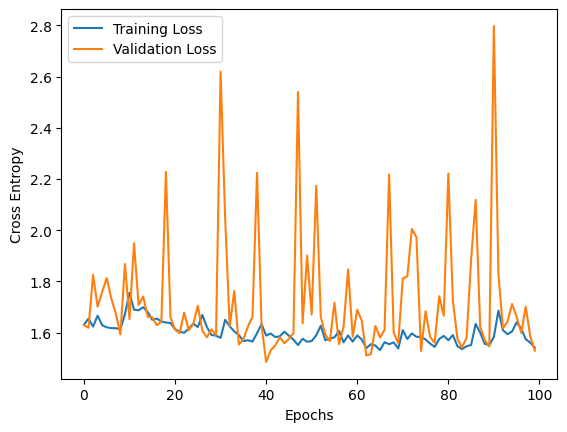

In [ ]:
#For the first 100 epochs.
plt.plot(Type_hist.history['loss'], label='Training Loss')
plt.plot(Type_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.savefig('model_training_history')
plt.show()

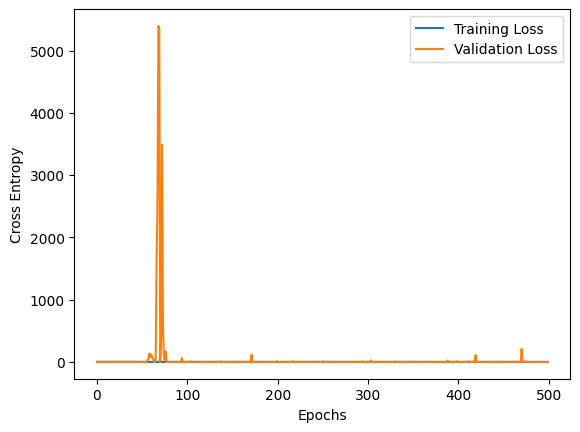

In [ ]:
#For 500 more epochs.
plt.plot(Type_hist.history['loss'], label='Training Loss')
plt.plot(Type_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.savefig('model_training_history')
plt.show()

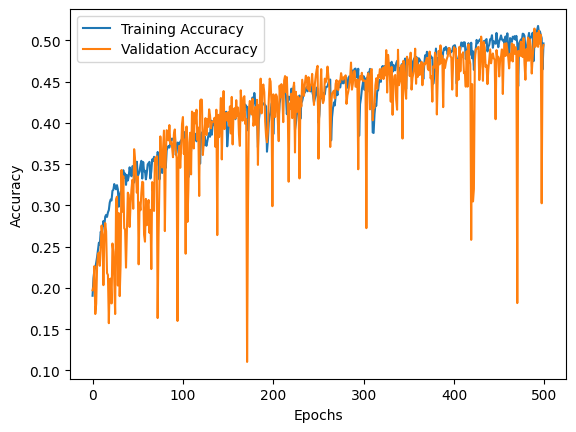

In [ ]:
#Plot for accuracy over 500 epochs.
plt.plot(Type_hist.history['accuracy'], label='Training Accuracy')
plt.plot(Type_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('model_training_history')
plt.show()

In [ ]:
Type_model.load_weights('/content/drive/MyDrive/Deep Learning/SavedModels/BestModelForType')

In [ ]:
#Evaluate the model on the test set.
result = Type_model.evaluate(TypeTest)

118/118 [==============================] - 14s 116ms/step - loss: 1.4179 - accuracy: 0.5191


In [ ]:
#Make predictions from test set.
Type_predictions = Type_model.predict(TypeTest)

118/118 [==============================] - 14s 117ms/step


In [ ]:
Type_predictions.shape

(3747, 9)

In [ ]:
print(Type_predictions[0])

[0.07558715 0.02483506 0.01093115 0.03120333 0.11110371 0.34519753
 0.32071775 0.00171897 0.07870525]


In [ ]:
#Run this if you would like to see the ground truths of the test set.
file_paths = TypeTest.file_paths
print(file_paths)
groundTruths = []
testImages = []
for path in file_paths:
  imgFile, groundTruth, img = path.rsplit('/', 2)
  groundTruths.append(groundTruth)
  testImages.append(img)

print(groundTruths)

In [ ]:
#Index the ground truths to compare with the highest index from the predictions.
testTruths = []
for i in range(len(groundTruths)):
  testTruths.append(TypeTest.class_names.index(groundTruths[i]))
print(testTruths)

In [ ]:
preds = np.argmax (Type_predictions, axis = 1)
tests = np.array(testTruths)
print(preds)
print(tests)

[5 5 4 ... 6 6 6]
[0 0 0 ... 8 8 8]


In [ ]:
predicted_labels = []
for i in range(len(preds)):
  predicted_labels.append(TypeTest.class_names[preds[i]])
#Uncomment if you'd like to see predictions vs. ground truths.
#print(predicted_labels)
#print(groundTruths)

([<matplotlib.axis.YTick at 0x7f13402ee320>,
 [Text(0, 0, 'Cab'),
  Text(0, 1, 'Convertible'),
  Text(0, 2, 'Coupe'),
  Text(0, 3, 'Hatchback'),
  Text(0, 4, 'Minivan'),
  Text(0, 5, 'SUV'),
  Text(0, 6, 'Sedan'),
  Text(0, 7, 'Van'),
  Text(0, 8, 'Wagon')])

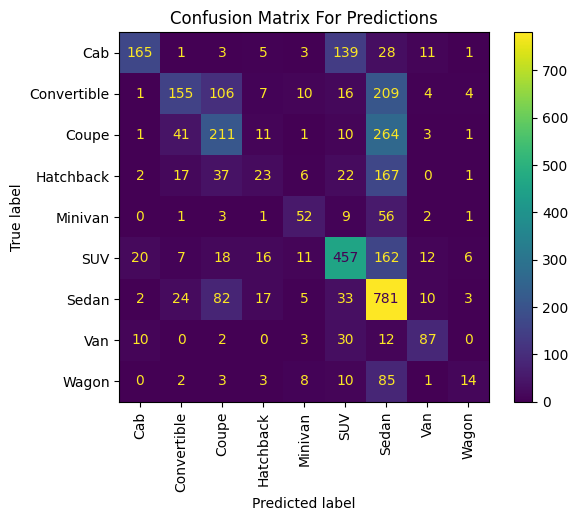

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusionMat = confusion_matrix(tests, preds)
dispConfMat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMat)
dispConfMat.plot()
plt.title('Confusion Matrix For Predictions')
plt.xticks(np.arange(9), TypeTest.class_names, rotation=90)
plt.yticks(np.arange(9), TypeTest.class_names)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(tests, preds))

              precision    recall  f1-score   support

           0       0.82      0.46      0.59       356
           1       0.62      0.30      0.41       512
           2       0.45      0.39      0.42       543
           3       0.28      0.08      0.13       275
           4       0.53      0.42      0.46       125
           5       0.63      0.64      0.64       709
           6       0.44      0.82      0.57       957
           7       0.67      0.60      0.64       144
           8       0.45      0.11      0.18       126

    accuracy                           0.52      3747
   macro avg       0.54      0.43      0.45      3747
weighted avg       0.54      0.52      0.50      3747



In [ ]:
Type_model.save('/content/drive/MyDrive/Deep Learning/SavedModels/VehicleTypeModel51.hdf5')
Type_model.save('/content/drive/MyDrive/Deep Learning/SavedModels/VehicleTypeModel51.h5')

#### We can see the amount of oscillations during training. So to fix this we can try to decrease out learning rate.

In [ ]:
with tf.device(device_name):
  Type_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Type_hist = Type_model.fit(TypeTrain, epochs=50, callbacks=Type_callbacks, validation_data=TypeVal)

Epoch 1/50
282/283 [============================>.] - ETA: 0s - loss: 1.3375 - accuracy: 0.4977
Epoch 1: val_accuracy did not improve from 0.51440
283/283 [==============================] - 56s 184ms/step - loss: 1.3373 - accuracy: 0.4976 - val_loss: 1.8116 - val_accuracy: 0.5051
Epoch 2/50
282/283 [============================>.] - ETA: 0s - loss: 1.3255 - accuracy: 0.5099
Epoch 2: val_accuracy did not improve from 0.51440
283/283 [==============================] - 47s 163ms/step - loss: 1.3255 - accuracy: 0.5097 - val_loss: 1.5491 - val_accuracy: 0.5033
Epoch 3/50
282/283 [============================>.] - ETA: 0s - loss: 1.3184 - accuracy: 0.5102
Epoch 3: val_accuracy did not improve from 0.51440
283/283 [==============================] - 53s 185ms/step - loss: 1.3181 - accuracy: 0.5103 - val_loss: 1.6513 - val_accuracy: 0.5033
Epoch 4/50
282/283 [============================>.] - ETA: 0s - loss: 1.3260 - accuracy: 0.5076
Epoch 4: val_accuracy did not improve from 0.51440
283/283 [=

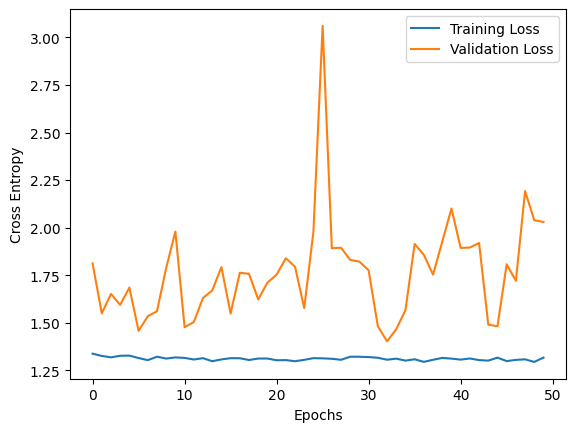

In [ ]:
#Loss for 50 epochs with learning rate = 1e-5.
plt.plot(Type_hist.history['loss'], label='Training Loss')
plt.plot(Type_hist.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy')
plt.savefig('model_training_history')
plt.show()

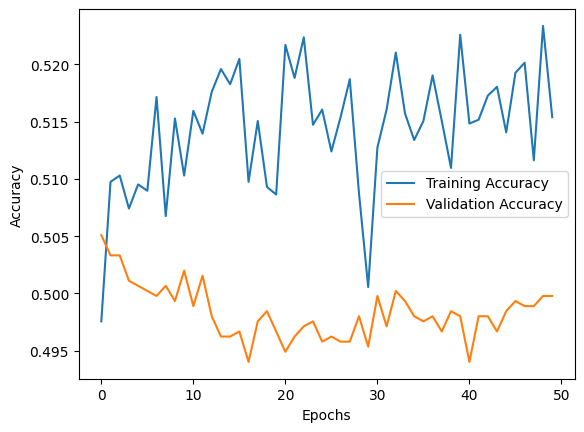

In [ ]:
##Accuracy for 50 epochs with learning rate = 1e-5.
plt.plot(Type_hist.history['accuracy'], label='Training Accuracy')
plt.plot(Type_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('model_training_history')
plt.show()

In [ ]:
#No longer huge oscillates, but is now stuck at 49/50%. Try learning rate = 1e-4

In [ ]:
with tf.device(device_name):
  Type_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Type_hist = Type_model.fit(TypeTrain, epochs=20, callbacks=Type_callbacks, validation_data=TypeVal)

Epoch 1/20
282/283 [============================>.] - ETA: 0s - loss: 1.2917 - accuracy: 0.5199
Epoch 1: val_accuracy did not improve from 0.51440
283/283 [==============================] - 53s 167ms/step - loss: 1.2912 - accuracy: 0.5202 - val_loss: 1.9875 - val_accuracy: 0.4953
Epoch 2/20
282/283 [============================>.] - ETA: 0s - loss: 1.2972 - accuracy: 0.5129
Epoch 2: val_accuracy did not improve from 0.51440
283/283 [==============================] - 51s 178ms/step - loss: 1.2969 - accuracy: 0.5130 - val_loss: 1.5484 - val_accuracy: 0.5042
Epoch 3/20
282/283 [============================>.] - ETA: 0s - loss: 1.2878 - accuracy: 0.5276
Epoch 3: val_accuracy did not improve from 0.51440
283/283 [==============================] - 48s 166ms/step - loss: 1.2877 - accuracy: 0.5276 - val_loss: 1.7758 - val_accuracy: 0.5002
Epoch 4/20
282/283 [============================>.] - ETA: 0s - loss: 1.2912 - accuracy: 0.5219
Epoch 4: val_accuracy did not improve from 0.51440
283/283 [=

In [ ]:
#Still no increase in accuracy.

## Simple Model

In [5]:
with tf.device(device_name):
  simpleModel = models.Sequential()
  simpleModel.add(data_augmentation)
  simpleModel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,1)))
  simpleModel.add(layers.MaxPooling2D((2,2)))
  simpleModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  simpleModel.add(layers.MaxPooling2D((2,2)))
  simpleModel.add(layers.Conv2D(64, (3, 3), activation='relu'))
  simpleModel.add(layers.Flatten())
  simpleModel.add(layers.Dense(64, activation='relu'))
  simpleModel.add(layers.Dropout(0.5))
  simpleModel.add(layers.Dense(9, activation='softmax'))

In [ ]:
simpleModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)       

In [ ]:
from keras.callbacks import ModelCheckpoint
simple_callbacks = [
    ModelCheckpoint(filepath="/content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel", 
                             monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')]

In [ ]:
with tf.device(device_name):
  simpleModel.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='sparse_categorical_crossentropy', metrics=['accuracy'])

simple_hist = simpleModel.fit(TypeTrain, epochs=50, callbacks=simple_callbacks, validation_data=TypeVal)

Epoch 1/50
283/283 [==============================] - ETA: 0s - loss: 7.3917 - accuracy: 0.2307
Epoch 1: val_accuracy improved from -inf to 0.25476, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel


283/283 [==============================] - 1598s 5s/step - loss: 7.3917 - accuracy: 0.2307 - val_loss: 2.0194 - val_accuracy: 0.2548
Epoch 2/50
283/283 [==============================] - ETA: 0s - loss: 2.0191 - accuracy: 0.2550
Epoch 2: val_accuracy improved from 0.25476 to 0.25698, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel


283/283 [==============================] - 57s 196ms/step - loss: 2.0191 - accuracy: 0.2550 - val_loss: 1.9818 - val_accuracy: 0.2570
Epoch 3/50
283/283 [==============================] - ETA: 0s - loss: 1.9967 - accuracy: 0.2542
Epoch 3: val_accuracy did not improve from 0.25698
283/283 [==============================] - 50s 174ms/step - loss: 1.9967 - accuracy: 0.2542 - val_loss: 1.9727 - val_accuracy: 0.2561
Epoch 4/50
282/283 [============================>.] - ETA: 0s - loss: 1.9920 - accuracy: 0.2560
Epoch 4: val_accuracy improved from 0.25698 to 0.25786, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel


283/283 [==============================] - 57s 197ms/step - loss: 1.9921 - accuracy: 0.2558 - val_loss: 1.9693 - val_accuracy: 0.2579
Epoch 5/50
283/283 [==============================] - ETA: 0s - loss: 1.9933 - accuracy: 0.2574
Epoch 5: val_accuracy improved from 0.25786 to 0.25964, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel


283/283 [==============================] - 54s 187ms/step - loss: 1.9933 - accuracy: 0.2574 - val_loss: 1.9709 - val_accuracy: 0.2596
Epoch 6/50
283/283 [==============================] - ETA: 0s - loss: 1.9948 - accuracy: 0.2584
Epoch 6: val_accuracy did not improve from 0.25964
283/283 [==============================] - 52s 180ms/step - loss: 1.9948 - accuracy: 0.2584 - val_loss: 1.9715 - val_accuracy: 0.2596
Epoch 7/50
282/283 [============================>.] - ETA: 0s - loss: 1.9923 - accuracy: 0.2578
Epoch 7: val_accuracy did not improve from 0.25964
283/283 [==============================] - 51s 176ms/step - loss: 1.9923 - accuracy: 0.2578 - val_loss: 1.9717 - val_accuracy: 0.2596
Epoch 8/50
282/283 [============================>.] - ETA: 0s - loss: 1.9913 - accuracy: 0.2574
Epoch 8: val_accuracy improved from 0.25964 to 0.26052, saving model to /content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel


283/283 [==============================] - 53s 186ms/step - loss: 1.9914 - accuracy: 0.2576 - val_loss: 1.9704 - val_accuracy: 0.2605
Epoch 9/50
282/283 [============================>.] - ETA: 0s - loss: 1.9877 - accuracy: 0.2583
Epoch 9: val_accuracy did not improve from 0.26052
283/283 [==============================] - 52s 179ms/step - loss: 1.9878 - accuracy: 0.2583 - val_loss: 1.9704 - val_accuracy: 0.2601
Epoch 10/50
282/283 [============================>.] - ETA: 0s - loss: 1.9902 - accuracy: 0.2579
Epoch 10: val_accuracy did not improve from 0.26052
283/283 [==============================] - 52s 181ms/step - loss: 1.9898 - accuracy: 0.2582 - val_loss: 1.9701 - val_accuracy: 0.2601
Epoch 11/50
282/283 [============================>.] - ETA: 0s - loss: 1.9906 - accuracy: 0.2579
Epoch 11: val_accuracy did not improve from 0.26052
283/283 [==============================] - 52s 182ms/step - loss: 1.9905 - accuracy: 0.2580 - val_loss: 1.9732 - val_accuracy: 0.2583
Epoch 12/50
283/283

283/283 [==============================] - 52s 180ms/step - loss: 1.9862 - accuracy: 0.2583 - val_loss: 1.9712 - val_accuracy: 0.2610
Epoch 19/50
283/283 [==============================] - ETA: 0s - loss: 1.9867 - accuracy: 0.2586
Epoch 19: val_accuracy did not improve from 0.26097
283/283 [==============================] - 53s 183ms/step - loss: 1.9867 - accuracy: 0.2586 - val_loss: 1.9703 - val_accuracy: 0.2610
Epoch 20/50
283/283 [==============================] - ETA: 0s - loss: 1.9872 - accuracy: 0.2583
Epoch 20: val_accuracy did not improve from 0.26097
283/283 [==============================] - 50s 173ms/step - loss: 1.9872 - accuracy: 0.2583 - val_loss: 1.9704 - val_accuracy: 0.2601
Epoch 21/50
283/283 [==============================] - ETA: 0s - loss: 1.9859 - accuracy: 0.2584
Epoch 21: val_accuracy did not improve from 0.26097
283/283 [==============================] - 52s 182ms/step - loss: 1.9859 - accuracy: 0.2584 - val_loss: 1.9702 - val_accuracy: 0.2601
Epoch 22/50
282/2

In [ ]:
#Not great at all.

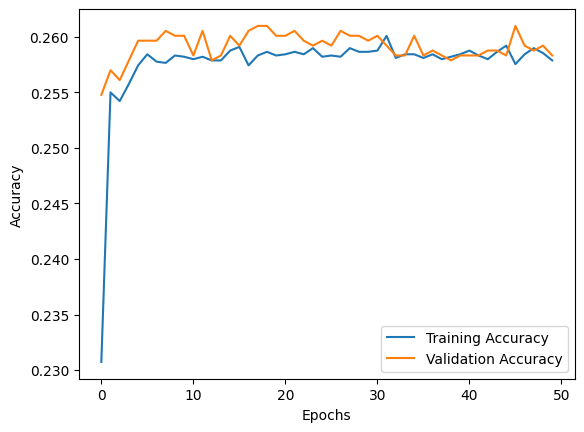

In [ ]:
#Plot for accuracy over 50 epochs.
plt.plot(simple_hist.history['accuracy'], label='Training Accuracy')
plt.plot(simple_hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('model_training_history')
plt.show()

In [6]:
simpleModel.load_weights('/content/drive/MyDrive/Deep Learning/SavedModels/SimpleModel')

In [ ]:
simpleModel.save('/content/drive/MyDrive/Deep Learning/SavedModels/SimpleVehicleTypeModel.hdf5')
simpleModel.save('/content/drive/MyDrive/Deep Learning/SavedModels/SimpleVehicleTypeModel.h5')

In [8]:
simple = tf.keras.models.load_model('/content/drive/MyDrive/Deep Learning/SavedModels/SimpleVehicleTypeModel.h5')

In [10]:
#Evaluate the model on the test set.
result = simple.evaluate(TypeTest)

118/118 [==============================] - 533s 4s/step - loss: 1.9832 - accuracy: 0.2570


In [11]:
#Make predictions from test set.
simple_predictions = simple.predict(TypeTest)

118/118 [==============================] - 13s 106ms/step


In [13]:
#Make ground truths of the test set.
file_paths = TypeTest.file_paths
groundTruths = []
testImages = []
for path in file_paths:
  imgFile, groundTruth, img = path.rsplit('/', 2)
  groundTruths.append(groundTruth)
  testImages.append(img)

#Index the ground truths to compare with the highest index from the predictions.
testTruths = []
for i in range(len(groundTruths)):
  testTruths.append(TypeTest.class_names.index(groundTruths[i]))

preds = np.argmax (simple_predictions, axis = 1)
tests = np.array(testTruths)
print(preds)
print(tests)

predicted_labels = []
for i in range(len(preds)):
  predicted_labels.append(TypeTest.class_names[preds[i]])
#Uncomment if you'd like to see predictions vs. ground truths.
#print(predicted_labels)
#print(groundTruths)

[6 6 6 ... 6 6 6]
[0 0 0 ... 8 8 8]


([<matplotlib.axis.YTick at 0x7fa2e3fe1660>,
 [Text(0, 0, 'Cab'),
  Text(0, 1, 'Convertible'),
  Text(0, 2, 'Coupe'),
  Text(0, 3, 'Hatchback'),
  Text(0, 4, 'Minivan'),
  Text(0, 5, 'SUV'),
  Text(0, 6, 'Sedan'),
  Text(0, 7, 'Van'),
  Text(0, 8, 'Wagon')])

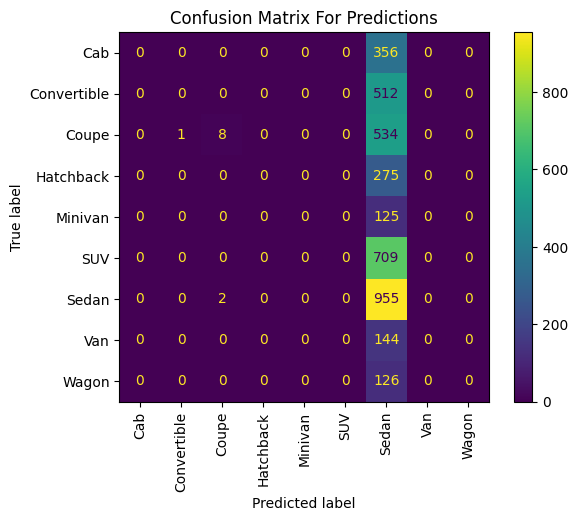

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusionMat = confusion_matrix(tests, preds)
dispConfMat = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMat)
dispConfMat.plot()
plt.title('Confusion Matrix For Predictions')
plt.xticks(np.arange(9), TypeTest.class_names, rotation=90)
plt.yticks(np.arange(9), TypeTest.class_names)

In [ ]:
#This model performs terribly and for some reason really favors the Sedan.

In [15]:
from sklearn.metrics import classification_report
print(classification_report(tests, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       356
           1       0.00      0.00      0.00       512
           2       0.80      0.01      0.03       543
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       125
           5       0.00      0.00      0.00       709
           6       0.26      1.00      0.41       957
           7       0.00      0.00      0.00       144
           8       0.00      0.00      0.00       126

    accuracy                           0.26      3747
   macro avg       0.12      0.11      0.05      3747
weighted avg       0.18      0.26      0.11      3747



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
